# Лабораторная работа №1: Геометрические преобразования изображений
Выполнила: студентка гр. 1384 Усачева Дарья.

## Задача
Реализовать на языке Python  с использованием библиотеки OpenCV программу, выполняющее геометрические преобразования изображения

## Входные данные
1.  цветное изображение в формате bmp, jpg 
2.  угол поворота $\alpha \in [0 .. 360)$  - целое число
3.  коэффициент $k \in (0..1]$ - рациональное число
4.  признак используемой интерполяционной схемы ( 0 – нулевого порядка, 1 – первого порядка, 2- третьего порядка).

## Выходные данные
Цветное изображение в формате bmp (result.bmp), являющиеся результатом следующих пребразований:
1.  Исходное изображение поворачивается  на $\alpha$  градусов против часовой стрелке
2.  Из получившегося изображения вырезается прямоугольник максимальной площади, вписаный в повернутое изображение
3.  Данное изображение увеличивается по оси Y в $1/k$ раз и уменьшается по оси Х в k раз.
4.  Результат с использованием интерполяции соответствующего порядка записывается в файл result.bmp

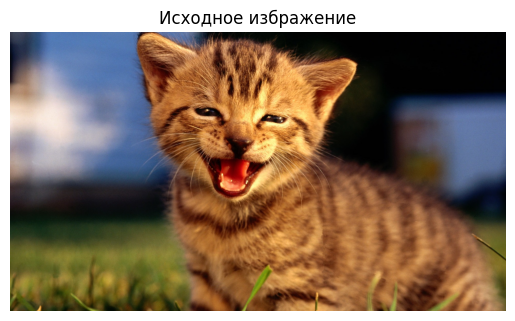

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

image_path = 'cat1.jpg'
angle = 30
k = 1/2
interpolation_flag = 2
image = cv2.imread(image_path)
if image is None:
    print("Не удалось загрузить изображение.")
def display_image(image, title=''):
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
display_image(image, "Исходное избражение")

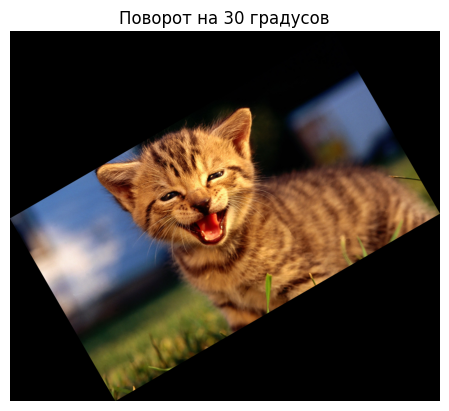

In [10]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    original_corners = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    ones = np.ones((4, 1))
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_w, new_h))
    
    original_corners_homogeneous = np.hstack([original_corners, ones])
    rotated_corners_homogeneous = rotation_matrix @ original_corners_homogeneous.T
    rotated_corners = rotated_corners_homogeneous.T[:, :2]
    
    return rotated_image, rotated_corners, new_w, new_h

rotated_image, rotated_corners, w, h = rotate_image(image,angle)

display_image(rotated_image, f"Поворот на {angle} градусов")


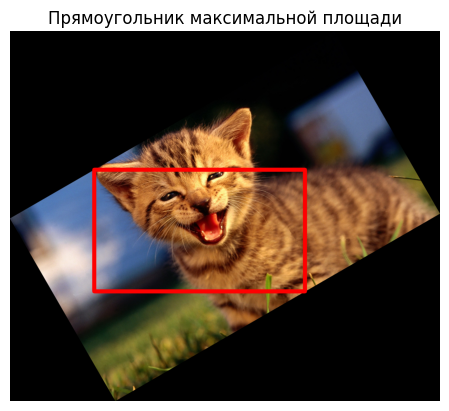

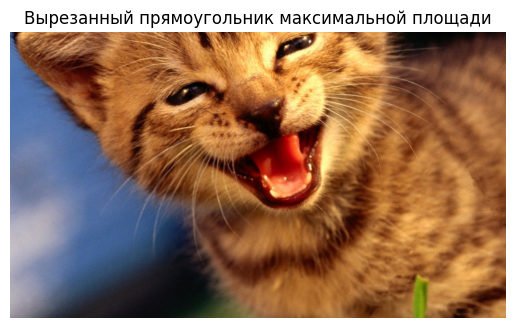

In [11]:
def get_line_equation(p1, p2):
    A = p2[1] - p1[1]
    B = p1[0] - p2[0]
    C = p2[0] * p1[1] - p1[0] * p2[1]
    return A, B, C

def find_max_inscribed_rectangle(rotated_corners, max_width, max_height, image):
    sides = []
    for i in range(4):
        p1 = rotated_corners[i]
        p2 = rotated_corners[(i + 1) % 4]
        A, B, C = get_line_equation(p1, p2)
        sides.append((A, B, C))

    def area(params):
        x, y, W, H = params
        return -W * H 

    def constraints(params):
        x, y, W, H = params
        rect_corners = [
            [x, y],
            [x + W, y],
            [x + W, y + H],
            [x, y + H]
        ]
        constraints = []
        for (A, B, C) in sides:
            for corner in rect_corners:
                constraints.append(-(A * corner[0] + B * corner[1] + C))
        constraints.append(W)
        constraints.append(H)
        return constraints

    initial_guess = [50, 50, 100, 100]

    result = minimize(
        area,
        initial_guess,
        constraints={"type": "ineq", "fun": constraints},
        bounds=[(0, None), (0, None), (0, max_width), (0, max_height)] 
    )

    x, y, W, H = map(int, result.x) 
    return x, y, W, H, image[y:y+H, x:x+W]

x, y, W, H , cropped_image = find_max_inscribed_rectangle(rotated_corners, w, h, rotated_image)
rect_corners = np.array([
    [x, y],
    [x + W, y],
    [x + W, y + H],
    [x, y + H]
], dtype=np.int32)
max_inscribed_rectangle = rotated_image.copy()
cv2.polylines(max_inscribed_rectangle, [rect_corners], isClosed=True, color=(0, 0, 255), thickness=20)

display_image(max_inscribed_rectangle, "Прямоугольник максимальной площади")

display_image(cropped_image,"Вырезанный прямоугольник максимальной площади")

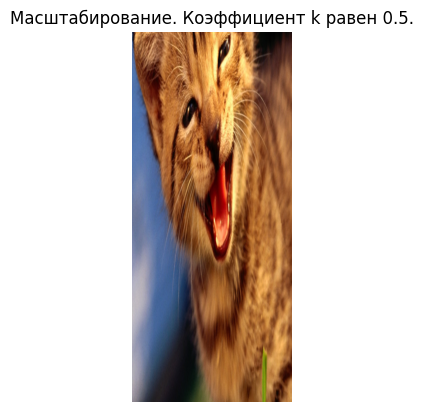

True

In [12]:
def resize_image(image, scale_x, scale_y, interpolation_flag):
    if interpolation_flag == 0:
        interpolation = cv2.INTER_NEAREST 
    elif interpolation_flag == 1:
        interpolation = cv2.INTER_LINEAR  
    elif interpolation_flag == 2:
        interpolation = cv2.INTER_CUBIC
    else:
        interpolation = cv2.INTER_LINEAR
    new_width = int(image.shape[1] * scale_x)
    new_height = int(image.shape[0] * scale_y)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=interpolation)
    return resized_image
resized_image = resize_image(cropped_image, k, 1/k, interpolation_flag)
display_image(resized_image, f"Масштабирование. Коэффициент k равен {k}.")
cv2.imwrite('result.bmp', resized_image)